In [1]:
# prep: import modules and get pwd
import pymysql
import seaborn as sns
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
query = ''' SELECT
    f.title,
    f.rental_rate,
    f.length,
    f.rating,
    f.special_features,
    f.replacement_cost,
    MAX(CASE WHEN r.rental_date IS NOT NULL THEN 1 ELSE 0 END) AS rented_in_may
FROM
    film f
LEFT JOIN
    inventory i USING (film_id)
LEFT JOIN
    rental r ON i.inventory_id = r.inventory_id AND MONTH(r.rental_date) = 5 AND YEAR (r.rental_date) = 2005
GROUP BY
    f.film_id, f.rental_rate, f.length, f.rating, f.replacement_cost;'''

data = pd.read_sql_query(query, engine)
data.head()

,title,rental_rate,length,rating,special_features,replacement_cost,rented_in_may
0,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",20.99,1
1,ACE GOLDFINGER,4.99,48,G,"Trailers,Deleted Scenes",12.99,0
2,ADAPTATION HOLES,2.99,50,NC-17,"Trailers,Deleted Scenes",18.99,1
3,AFFAIR PREJUDICE,2.99,117,G,"Commentaries,Behind the Scenes",26.99,1
4,AFRICAN EGG,2.99,130,G,Deleted Scenes,22.99,1


In [4]:
data.shape

(1000, 7)

In [5]:
data['rented_in_may'].value_counts()

1    686
0    314
Name: rented_in_may, dtype: int64

In [6]:
data.describe()

,rental_rate,length,replacement_cost,rented_in_may
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.980000,115.272000,19.984000,0.686000
std,1.646393,40.426332,6.050833,0.464349
min,0.990000,46.000000,9.990000,0.000000
25%,0.990000,80.000000,14.990000,0.000000
50%,2.990000,114.000000,19.990000,1.000000
75%,4.990000,149.250000,24.990000,1.000000
max,4.990000,185.000000,29.990000,1.000000


In [7]:
data.isna().sum() #no null values

title               0
rental_rate         0
length              0
rating              0
special_features    0
replacement_cost    0
rented_in_may       0
dtype: int64

In [ ]:
data.head()

In [ ]:
# #would like to split the special_features based on comma to see if a specific attribute will influence
# movies = pd.concat([data, data['special_features'].str.split(',', expand=True)], axis=1)

# movies = movies.drop(['special_features'], axis=1)
# movies.head()

In [ ]:
# movies = movies.rename(columns={0:'feature_1', 1:'feature_2', 2: 'feature_3', 3:'feature_4'})
# movies.head()

In [ ]:
# movies['feature_1'] = movies['feature_1'].fillna('None')
# movies['feature_2'] = movies['feature_2'].fillna('None')
# movies['feature_3'] = movies['feature_3'].fillna('None')
# movies['feature_4'] = movies['feature_4'].fillna('None')


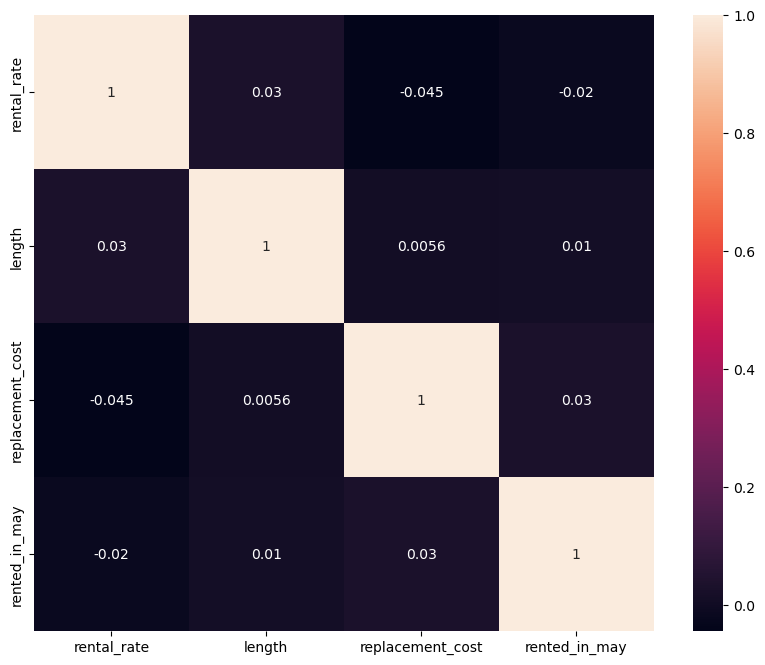

In [9]:
import matplotlib.pyplot as plt
# look for multicolinearity (some columns having almost identical correlation to other variables)
# why can't we look for correlation with our target variable (status)?
corr_matrix=data.corr()  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

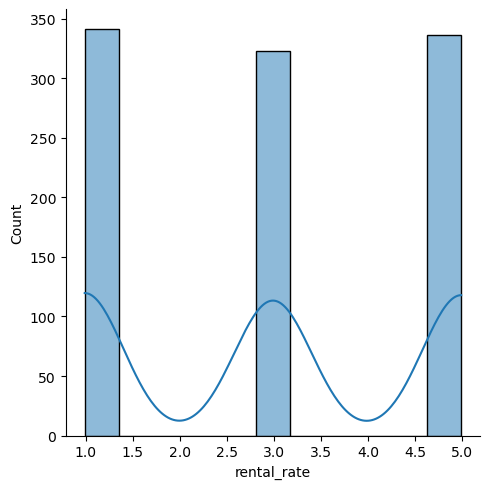

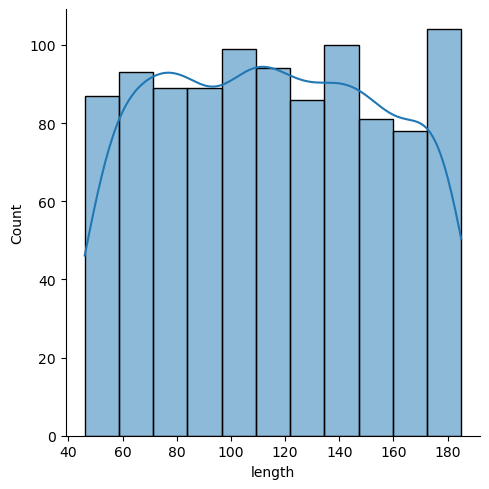

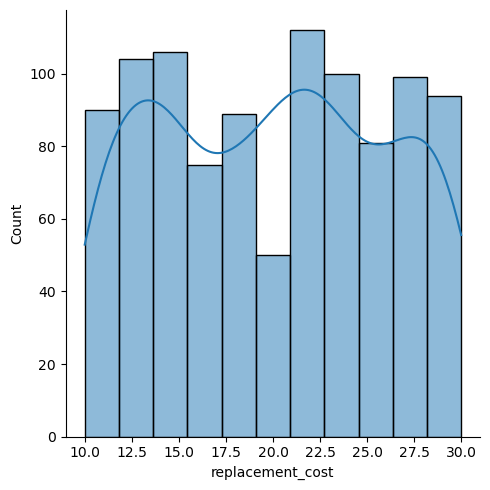

In [10]:
sns.displot(data['rental_rate'], kde=True)
plt.show()

sns.displot(data['length'], kde=True)
plt.show()

sns.displot(data['replacement_cost'], kde=True)
plt.show()

In [11]:
# Need to X-y split and train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = data['rented_in_may']
X = data.drop('rented_in_may', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1452)

In [16]:
X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_train_norm

,rental_rate,length,replacement_cost
0,1.0,0.093525,0.40
1,1.0,0.309353,0.65
2,0.5,0.388489,1.00
3,0.5,0.223022,0.70
4,1.0,0.402878,0.10
...,...,...,...
795,0.0,0.841727,0.90
796,0.5,0.028777,0.45
797,0.0,0.669065,0.70
798,0.5,0.949640,0.40


In [13]:
data.dtypes

title                object
rental_rate         float64
length                int64
rating               object
special_features     object
replacement_cost    float64
rented_in_may         int64
dtype: object

In [19]:
X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating', 'special_features'],
                             drop_first=True)
X_train_cat.head()

,title,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
464,INTERVIEW LIAISONS,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
59,BEAST HUNCHBACK,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
321,FLATLINERS KILLER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
677,PICKUP DRIVING,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
767,SCARFACE BANG,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# features = ['Deleted Scenes', 'Trailers', 'Commentaries', 'Behind the Scenes', 'None']
# features

In [ ]:
# def strings_to_onehot(categories_column1, categories_column2, categories_column3, categories_column4):     

#      # We will create a one-hot matrix, the first step is to create a zero-matrix 
#      # of dimmensions number of datapoints X number of categories
#      one_hot_matrix = np.zeros( (len(categories_column1), len(features)), dtype=int )

#      # This loop sets to 1 the right slot in each row for every example in our data
#      for row, c1, c2, c3, c4 in zip(one_hot_matrix, categories_column1, categories_column2, categories_column3, categories_column4):
#             category_index1 = features.index(c1)
#             category_index2 = features.index(c2)
#             category_index3 = features.index(c3)
#             category_index4 = features.index(c4)
#             row[category_index1] = 1
#             row[category_index2] = 1
#             row[category_index3] = 1
#             row[category_index4] = 1

#      # Now, let's build and return a DataFrame with the values
#      return pd.DataFrame(columns = features, data = one_hot_matrix)

# # onehot_types is the DataFrame with the categories in one-hot encoding

# type1 = X_train['feature_1'].to_list()
# type2 = X_train['feature_2'].to_list()
# type3 = X_train['feature_3'].to_list()
# type4 = X_train['feature_4'].to_list()
# onehot_types = strings_to_onehot(type1, type2, type3, type4)
# onehot_types.shape

In [ ]:
# onehot_types = onehot_types.drop(['None', 'Trailers'], axis=1)
# onehot_types.shape

In [ ]:
# print(X_train_rat.shape)
# print(onehot_types.shape)

# #X_train_cat = pd.concat([X_train_rat['', onehot_types], axis=1) - concatenating increasing the rows from 800 to 956?!

# X_train_cat['']

In [34]:
X_train_cat = X_train_cat.drop(['title'], axis=1)
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
464,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
59,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
677,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
767,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [35]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [36]:
print(X_train_transformed)

[[1.         0.09352518 0.4        ... 0.         0.         0.        ]
 [1.         0.30935252 0.65       ... 0.         0.         0.        ]
 [0.5        0.38848921 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.66906475 0.7        ... 0.         1.         0.        ]
 [0.5        0.94964029 0.4        ... 0.         0.         0.        ]
 [1.         0.82733813 0.6        ... 0.         0.         0.        ]]


In [37]:
y_train

464    1
59     1
321    1
677    1
767    1
      ..
849    1
82     1
188    0
452    0
99     1
Name: rented_in_may, Length: 800, dtype: int64

In [38]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [41]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)
X_test_norm.head()

,0,1,2
0,0.5,0.546763,0.9
1,0.5,0.438849,0.2
2,1.0,0.755396,0.6
3,1.0,0.647482,0.8
4,0.5,0.690647,0.2


In [43]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating', 'special_features'],
                            drop_first=True)
X_test_cat = X_test_cat.drop(['title'], axis=1)

In [45]:
X_test_cat.columns

Index(['rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R',
       'special_features_Commentaries',
       'special_features_Commentaries,Behind the Scenes',
       'special_features_Commentaries,Deleted Scenes',
       'special_features_Commentaries,Deleted Scenes,Behind the Scenes',
       'special_features_Deleted Scenes',
       'special_features_Deleted Scenes,Behind the Scenes',
       'special_features_Trailers',
       'special_features_Trailers,Behind the Scenes',
       'special_features_Trailers,Commentaries',
       'special_features_Trailers,Commentaries,Behind the Scenes',
       'special_features_Trailers,Commentaries,Deleted Scenes',
       'special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes',
       'special_features_Trailers,Deleted Scenes',
       'special_features_Trailers,Deleted Scenes,Behind the Scenes'],
      dtype='object')

In [46]:
X_train_cat.columns

Index(['rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R',
       'special_features_Commentaries',
       'special_features_Commentaries,Behind the Scenes',
       'special_features_Commentaries,Deleted Scenes',
       'special_features_Commentaries,Deleted Scenes,Behind the Scenes',
       'special_features_Deleted Scenes',
       'special_features_Deleted Scenes,Behind the Scenes',
       'special_features_Trailers',
       'special_features_Trailers,Behind the Scenes',
       'special_features_Trailers,Commentaries',
       'special_features_Trailers,Commentaries,Behind the Scenes',
       'special_features_Trailers,Commentaries,Deleted Scenes',
       'special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes',
       'special_features_Trailers,Deleted Scenes',
       'special_features_Trailers,Deleted Scenes,Behind the Scenes'],
      dtype='object')

In [47]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [50]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.705

In [51]:
print(y_test.value_counts())

1    143
0     57
Name: rented_in_may, dtype: int64


In [52]:
pd.Series(predictions).value_counts()

1    190
0     10
dtype: int64

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  4,  53],
       [  6, 137]])